In [1]:
from IPython.display import FileLink
import pandas as pd
import pandas.rpy.common as com
import brewer2mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import collections
from matplotlib import gridspec
from numpy import nan, min, array 
import itertools
from mpltools import style
style.use("ggplot")
%matplotlib inline
%load_ext rpy2.ipython

/opt/anaconda/lib/python2.7/site-packages/pandas/rpy/__init__.py:8: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2, found here: http://rpy.sourceforge.net
  "like rpy2, found here: http://rpy.sourceforge.net", FutureWarning)


In [2]:
%%R
library(plyr)
library(dplyr)
library(phyloseq)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
%%R
physeq = import_biom("data/otu_table_JSON_wtax.biom", "data/otusn_JSON.tree")
sample.data = import_qiime_sample_data("data/JSON_mapping_file.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq = prune_samples((physeq.md$Treatment %in% c("NTR","NTH", "PTH", "PTR")), physeq)

In [4]:
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["axes.edgecolor"] = "#151515"
mpl.rcParams["grid.color"] = "#959595"
mpl.rcParams["grid.alpha"] = "0.50"
mpl.rcParams["font.size"] = 7.5

In [22]:
def get_l2fc_df(df_fp, taxon, rank):
    df = pd.read_csv(df_fp, sep=",")
    df_subset = df[df[rank]==taxon]
    return df_subset, df_subset["OTU"]

def get_tree_df(physeq_str, OTUs):
    subset_fn_str = "prune_taxa(OTUs, %s)" %physeq_str
    %Rpush subset_fn_str
    %Rpush OTUs
    %R OTUs = as.character(OTUs)
    %R ps = eval(parse(text=subset_fn_str))
    %R tree_dfs = phyloseq:::tree_layout(phy_tree(ps), ladderize="right")
    %R tax = data.frame(tax_table(ps), stringsAsFactors = FALSE)
    %R tax$OTU = rownames(tax)
    %R tax[is.na(tax)] <- 'unassigned'
    %R edge_df = left_join(data.frame(tree_dfs$edgeDT), tax)
    %R edge_df$OTU = factor(edge_df$OTU)
    %R vert_df = data.frame(tree_dfs$vertDT)
    edge_df = com.load_data("edge_df")
    vert_df = com.load_data("vert_df")
    return edge_df, vert_df

def add_tree_info(tip_df, l2fc_df):
    l2fc_df = l2fc_df.merge(tip_df[["y","OTU"]], 
                            left_on="OTU", 
                            right_on="OTU")
    return l2fc_df

def get_tax_colordict(tip_df, color_rank):
    cats = set(tip_df[color_rank].dropna())
    c_list = []
    for m in ["Set3", "Dark2", "Accent", "Set1"]:
        colors = brewer2mpl.get_map(m, "qualitative", 8).hex_colors
        [c_list.append(c) for c in colors]
    color_dict = dict(itertools.izip(cats, itertools.cycle(c_list)))
    color_dict["unassigned"] = "#505050"
    return color_dict

def get_responders(l2fc_df, Till):
    min_padj = l2fc_df[["OTU","padj","Till"]].groupby(["Till","OTU"]).min()
    t = min_padj["padj"]
    tmp = t[Till]
    rsp = tmp[tmp<0.10].index.tolist()
    return rsp
    
    
def make_tree_fig(taxon, taxon_rank, color_rank, l2fc_fp, physeq_str, lw_tax = 3, leg_spacing = 0.25, 
                  save_fn = None, pt_size = 50):
    l2fc_df, otus = get_l2fc_df(l2fc_fp, taxon, taxon_rank)
    edge_df, vert_df = get_tree_df(physeq_str, otus.tolist())
    tip_df = edge_df[edge_df["OTU"].notnull()]
    l2fc_df = add_tree_info(tip_df, l2fc_df)
    tax_colors = get_tax_colordict(tip_df, color_rank)
        
    Month = map(str,["July","Sept","Oct","Nov"])
    scaleFactor = 0.125
    
    RNA_rspdrs = get_responders(l2fc_df, "NT")
    DNA_rspdrs = get_responders(l2fc_df, "PT")
   

    df_pivot = l2fc_df.pivot_table(index=["y"], columns=["Till","Month"], values="log2FoldChange")
    figHeight = min(array([df_pivot.shape[0]*scaleFactor, 20]))

    gs = gridspec.GridSpec(nrows=1, ncols=5, width_ratios=[6,2.25,2.25,4*.75,4*.75])

    fig = plt.figure()
    fig.set_size_inches((6,figHeight))
    #fig.set_size_inches((8,20))
    fig.subplots_adjust(wspace=0.05)

    cm = brewer2mpl.get_map('RdYlBu', 'diverging', 5, reverse=True).mpl_colormap
    
    edge_segments = edge_df.apply(lambda row: [(row["xleft"], row["y"]-1), (row["xright"], row["y"]-1)], axis = 1).values
    edge_collection = collections.LineCollection(segments = edge_segments, color="k", linewidths = 1.5)
    
    vert_segments = vert_df.apply(lambda row: [(row["x"], row["vmin"]-1), (row["x"], row["vmax"]-1)], axis = 1).values
    vert_collection = collections.LineCollection(segments = vert_segments, color="k", linewidths = 1.5)

    max_right = tip_df["xright"].max() * 1.05
    buff = 0.025
    verts = tip_df.apply(lambda row: [(row["xright"] + buff, row["y"] - 1.5), 
                                      (row["xright"] + buff, row["y"] - 0.5),
                                      (max_right, row["y"] - 0.5), 
                                      (max_right, row["y"] - 1.5)], axis = 1).values
    rect_collection = collections.PolyCollection(verts, 
                                             facecolors = tip_df.apply(lambda x: tax_colors[x[color_rank]], axis = 1),
                                             alpha = 0.75)
    
    ax1 = fig.add_subplot(gs[0])
    ax1.add_collection(edge_collection)
    ax1.add_collection(vert_collection)
    ax1.add_collection(rect_collection)
    ax1.set_xlim(edge_df["xleft"].min() - edge_df["xright"].max() * 0.05, edge_df["xright"].max() * 1.05)
    ax1.set_ylim(edge_df["y"].min() - edge_df["y"].max() * 0.05, edge_df["y"].max() * 1.05)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_frame_on(False)
    ax1.grid(False)
    
    label_df = edge_df[edge_df["OTU"].notnull()]
    ax_label = fig.add_subplot(gs[1], sharey = ax1)
    ax_label.set_frame_on(False)
    ax_label.set_xticks([])
    ax_label.set_xticklabels([])
    ax_label.set_yticks([])
    for y, l  in zip(label_df.y, label_df.OTU):
        ax_label.text(x = 0, y = y - 0.75, s = l, fontsize=6)
    #ax_label.text(x = 0, y = [1,2,3,4,5], s = "test")
    
    ax2 = fig.add_subplot(gs[2], sharey = ax1)
    criterion2 = tip_df["OTU"].map(lambda x: x in RNA_rspdrs)
    criterion3 = tip_df["OTU"].map(lambda x: x in DNA_rspdrs)
    cell_rspndrs_tips = tip_df[criterion2]
    xyl_rspndrs_tips = tip_df[criterion3]
    ax2.scatter(x = [1 for i in cell_rspndrs_tips.y], 
                y = cell_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#377eb8")
    ax2.scatter(x = [2 for i in xyl_rspndrs_tips.y], 
                y = xyl_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#4daf4a")
    ax2.set_frame_on(False)
    ax2.set_xlim([0,3])
    ax2.set_xticks([1,2])
    ax2.set_xticklabels(["NT","PT"], rotation = 90, ha = "left", size = 8)
    ax2.set_yticks([])

    vmin = -3.0 #l2fc_df["log2FoldChange"].quantile(0.05)
    vmax = 3.0 #l2fc_df["log2FoldChange"].quantile(0.95)

    ax3 = fig.add_subplot(gs[3], sharey = ax1)
    ax3.set_xticks(range(len(Month)))
    ax3.set_xticklabels(Month)
    ax3.set_yticklabels([])
    ax3.set_title("NT")
    ax3.set_xlabel("Month")
    df = df_pivot["NT"]
    im = ax3.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
    ax3.grid(False)

    ax4 = fig.add_subplot(gs[4], sharey = ax3)
    ax4.set_xticks(range(len(Month)))
    ax4.set_xticklabels(Month)
    ax4.set_yticklabels([])
    ax4.yaxis.tick_right()
    ax4.set_title("PT")
    ax4.set_xlabel("Month")
    df = df_pivot["PT"]
    ax4.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
    ax4.grid(False)

    box = ax4.get_position()
    cax = fig.add_axes([box.xmax + 0.05, box.ymin + 2 * box.height / 3, 0.02, box.height / 3])
    cb = fig.colorbar(im, cax = cax)
    cb.set_label(r"log$_{2}$ Fold Change")

    proxy_artists = [plt.Rectangle((0,0),1,1,fc=tax_colors[i],alpha=0.75) 
                     for i in tip_df.sort("y")[color_rank].unique().tolist()]
    leg = ax1.legend(proxy_artists, 
                     tip_df.sort("y")[color_rank].unique().tolist(),
                     bbox_to_anchor = (0, -leg_spacing),
                     loc = 2, ncol = 2,
                     prop={'size':10,'style':"italic"}, labelspacing = 0.2)
    leg.set_frame_on(False)
    
    if save_fn:
        fig.savefig(save_fn, bbox_extra_artists=(leg, cax), bbox_inches='tight')

In [6]:
%%R
df.l2fc = df = read.table("data/l2fc_NTvsPT_all", sep=",", header = TRUE, stringsAsFactors = FALSE)
PT.otus = subset(df.l2fc, log2FoldChange < 0)$OTU
head(PT.otus)
physeq.PS.PT = prune_taxa(DNA.otus, physeq.PS)

Error in prune_taxa(DNA.otus, physeq.PS) : 
  error in evaluating the argument 'taxa' in selecting a method for function 'prune_taxa': Error: object 'DNA.otus' not found


Joining by: "OTU"


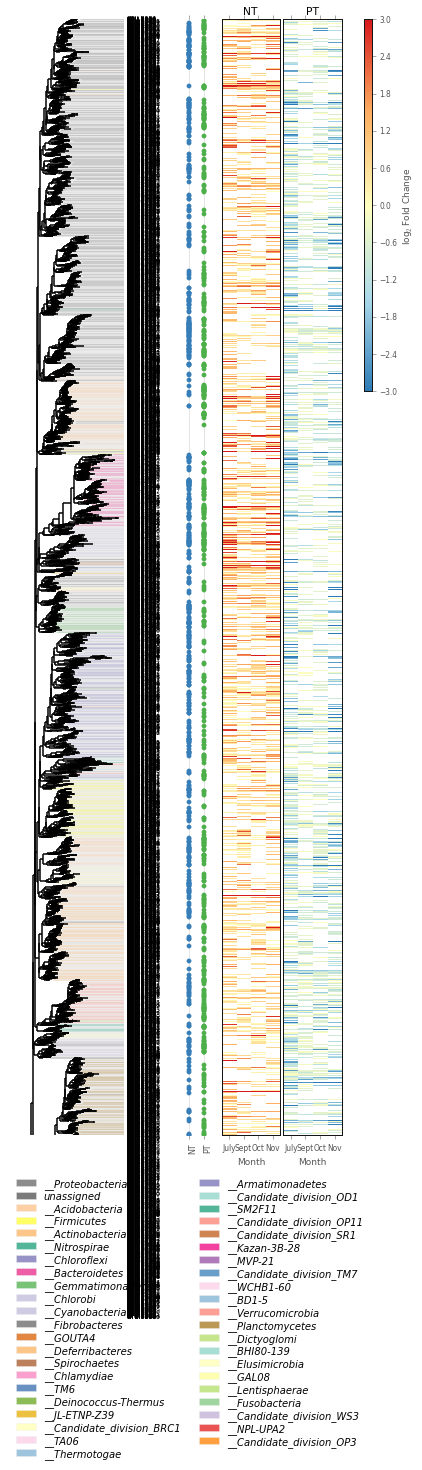

In [23]:
make_tree_fig("Bacteria", "Rank1", "Rank2", "data/l2fc_NTvsPT_all", "physeq", 
              save_fn = "figs/tree.png", lw_tax = 1, leg_spacing = 0.03,
              pt_size = 18)

In [12]:
FileLink("/home/chantal/RNASIP/data/figs/RNADNA_tree.pdf")

/home/chantal/RNASIP/data/figs/RNADNA_tree.pdf

In [24]:
%%R
df.l2fc = df = read.table("data/l2fc_NTvsPT_all", sep=",", header = TRUE, stringsAsFactors = FALSE)
df.l2fc.sub = subset(df, padj <= 0.10)
list.OTUs= select(df.l2fc.sub, OTU)
df.l2fc.OTUs = subset(df, OTU %in% list.OTUs$OTU)
print(head(df.l2fc.OTUs))
write.table(df.l2fc.OTUs, "data/l2fc_NTvsPT_all.responders.csv", row.names = FALSE, sep = ",")

   Month      OTU log2FoldChange     lfcSE         padj    Rank1
6   July  OTU.726     -1.6459499 0.6036527 0.0454724099 Bacteria
14  July OTU.1144     -0.9629112 0.3469088 0.0414750665 Bacteria
20  July OTU.2293      2.9859561 1.0395191 0.0342047039 Bacteria
22  July  OTU.580      1.7993629 0.4123640 0.0004924701 Bacteria
26  July OTU.4373     -2.3904478 1.0199891 0.0977774733 Bacteria
28  July OTU.5023      0.6271999 0.4965322 0.4322895882 Bacteria
             Rank2    Rank3                  Rank4 Rank5 Rank6 Rank7 Rank8 Till
6  __Acidobacteria   __S035 __uncultured_bacterium  <NA>  <NA>  <NA>  <NA>   PT
14 __Acidobacteria   __S035 __uncultured_bacterium  <NA>  <NA>  <NA>  <NA>   PT
20 __Acidobacteria   __S035 __uncultured_bacterium  <NA>  <NA>  <NA>  <NA>   NT
22 __Acidobacteria   __S035 __uncultured_bacterium  <NA>  <NA>  <NA>  <NA>   NT
26 __Acidobacteria   __S035 __uncultured_bacterium  <NA>  <NA>  <NA>  <NA>   PT
28 __Acidobacteria __BPC102 __uncultured_bacterium  <NA>  <NA>  <

###Tree fxn with no OTUs labled

In [108]:
def get_l2fc_df(df_fp, taxon, rank):
    df = pd.read_csv(df_fp, sep=",")
    df_subset = df[df[rank]==taxon]
    return df_subset, df_subset["OTU"]

def get_tree_df(physeq_str, OTUs):
    subset_fn_str = "prune_taxa(OTUs, %s)" %physeq_str
    %Rpush subset_fn_str
    %Rpush OTUs
    %R OTUs = as.character(OTUs)
    %R ps = eval(parse(text=subset_fn_str))
    %R tree_dfs = phyloseq:::tree_layout(phy_tree(ps), ladderize="right")
    %R tax = data.frame(tax_table(ps), stringsAsFactors = FALSE)
    %R tax$OTU = rownames(tax)
    %R tax[is.na(tax)] <- 'unassigned'
    %R edge_df = left_join(data.frame(tree_dfs$edgeDT), tax)
    %R edge_df$OTU = factor(edge_df$OTU)
    %R vert_df = data.frame(tree_dfs$vertDT)
    edge_df = com.load_data("edge_df")
    vert_df = com.load_data("vert_df")
    return edge_df, vert_df

def add_tree_info(tip_df, l2fc_df):
    l2fc_df = l2fc_df.merge(tip_df[["y","OTU"]], 
                            left_on="OTU", 
                            right_on="OTU")
    return l2fc_df

def get_tax_colordict(tip_df, color_rank):
    cats = set(tip_df[color_rank].dropna())
    c_list = []
    for m in ["Set3", "Dark2", "Accent", "Set1"]:
        colors = brewer2mpl.get_map(m, "qualitative", 8).hex_colors
        [c_list.append(c) for c in colors]
    color_dict = dict(itertools.izip(cats, itertools.cycle(c_list)))
    color_dict["unassigned"] = "#505050"
    return color_dict

def get_responders(l2fc_df, Till):
    min_padj = l2fc_df[["OTU","padj","Till"]].groupby(["Till","OTU"]).min()
    t = min_padj["padj"]
    tmp = t[Till]
    rsp = tmp[tmp<0.10].index.tolist()
    return rsp
    
    
def make_tree_fig(taxon, taxon_rank, color_rank, l2fc_fp, physeq_str, lw_tax = 3, leg_spacing = 0.25, 
                  save_fn = None, pt_size = 50):
    l2fc_df, otus = get_l2fc_df(l2fc_fp, taxon, taxon_rank)
    edge_df, vert_df = get_tree_df(physeq_str, otus.tolist())
    tip_df = edge_df[edge_df["OTU"].notnull()]
    l2fc_df = add_tree_info(tip_df, l2fc_df)
    tax_colors = get_tax_colordict(tip_df, color_rank)
        
    Month = map(str,["July","Sept","Oct","Nov"])
    scaleFactor = 0.125
    
    RNA_rspdrs = get_responders(l2fc_df, "NT")
    DNA_rspdrs = get_responders(l2fc_df, "PT")
   

    df_pivot = l2fc_df.pivot_table(index=["y"], columns=["Till","Month"], values="log2FoldChange")
    figHeight = min(array([df_pivot.shape[0]*scaleFactor, 20]))

    gs = gridspec.GridSpec(nrows=1, ncols=4, width_ratios=[6,2.25,4*.75,4*.75])

    fig = plt.figure()
    fig.set_size_inches((6,figHeight))
    #fig.set_size_inches((8,20))
    fig.subplots_adjust(wspace=0.05)

    cm = brewer2mpl.get_map('RdYlBu', 'diverging', 5, reverse=True).mpl_colormap
    
    edge_segments = edge_df.apply(lambda row: [(row["xleft"], row["y"]-1), (row["xright"], row["y"]-1)], axis = 1).values
    edge_collection = collections.LineCollection(segments = edge_segments, color="k", linewidths = 1.5)
    
    vert_segments = vert_df.apply(lambda row: [(row["x"], row["vmin"]-1), (row["x"], row["vmax"]-1)], axis = 1).values
    vert_collection = collections.LineCollection(segments = vert_segments, color="k", linewidths = 1.5)

    max_right = tip_df["xright"].max() * 1.05
    buff = 0.025
    verts = tip_df.apply(lambda row: [(row["xright"] + buff, row["y"] - 1.5), 
                                      (row["xright"] + buff, row["y"] - 0.5),
                                      (max_right, row["y"] - 0.5), 
                                      (max_right, row["y"] - 1.5)], axis = 1).values
    rect_collection = collections.PolyCollection(verts, 
                                             facecolors = tip_df.apply(lambda x: tax_colors[x[color_rank]], axis = 1),
                                             alpha = 0.75)
    
    ax1 = fig.add_subplot(gs[0])
    ax1.add_collection(edge_collection)
    ax1.add_collection(vert_collection)
    ax1.add_collection(rect_collection)
    ax1.set_xlim(edge_df["xleft"].min() - edge_df["xright"].max() * 0.05, edge_df["xright"].max() * 1.05)
    ax1.set_ylim(edge_df["y"].min() - edge_df["y"].max() * 0.05, edge_df["y"].max() * 1.05)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_frame_on(False)
    ax1.grid(False)
    
    #label_df = edge_df[edge_df["OTU"].notnull()]
    #ax_label = fig.add_subplot(gs[1], sharey = ax1)
    #ax_label.set_frame_on(False)
    #ax_label.set_xticks([])
    #ax_label.set_xticklabels([])
    #ax_label.set_yticks([])
    #for y, l  in zip(label_df.y, label_df.OTU):
     #   ax_label.text(x = 0, y = y - 0.75, s = l, fontsize=6)
    #ax_label.text(x = 0, y = [1,2,3,4,5], s = "test")
    
    ax2 = fig.add_subplot(gs[1], sharey = ax1)
    criterion2 = tip_df["OTU"].map(lambda x: x in RNA_rspdrs)
    criterion3 = tip_df["OTU"].map(lambda x: x in DNA_rspdrs)
    cell_rspndrs_tips = tip_df[criterion2]
    xyl_rspndrs_tips = tip_df[criterion3]
    ax2.scatter(x = [1 for i in cell_rspndrs_tips.y], 
                y = cell_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#377eb8")
    ax2.scatter(x = [2 for i in xyl_rspndrs_tips.y], 
                y = xyl_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#4daf4a")
    ax2.set_frame_on(False)
    ax2.set_xlim([0,3])
    ax2.set_xticks([1,2])
    ax2.set_xticklabels(["NT","PT"], rotation = 90, ha = "left", size = 8)
    ax2.set_yticks([])

    vmin = -3.0 #l2fc_df["log2FoldChange"].quantile(0.05)
    vmax = 3.0 #l2fc_df["log2FoldChange"].quantile(0.95)

    ax3 = fig.add_subplot(gs[2], sharey = ax1)
    ax3.set_xticks(range(len(Month)))
    ax3.set_xticklabels(Month)
    ax3.set_yticklabels([])
    ax3.set_title("NT")
    ax3.set_xlabel("Month")
    df = df_pivot["NT"]
    im = ax3.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
    ax3.grid(False)

    ax4 = fig.add_subplot(gs[3], sharey = ax3)
    ax4.set_xticks(range(len(Month)))
    ax4.set_xticklabels(Month)
    ax4.set_yticklabels([])
    ax4.yaxis.tick_right()
    ax4.set_title("PT")
    ax4.set_xlabel("Month")
    df = df_pivot["PT"]
    ax4.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
    ax4.grid(False)

    box = ax4.get_position()
    cax = fig.add_axes([box.xmax + 0.05, box.ymin + 2 * box.height / 3, 0.02, box.height / 3])
    cb = fig.colorbar(im, cax = cax)
    cb.set_label(r"log$_{2}$ Fold Change")

    proxy_artists = [plt.Rectangle((0,0),1,1,fc=tax_colors[i],alpha=0.75) 
                     for i in tip_df.sort("y")[color_rank].unique().tolist()]
    leg = ax1.legend(proxy_artists, 
                     tip_df.sort("y")[color_rank].unique().tolist(),
                     bbox_to_anchor = (0, -leg_spacing),
                     loc = 2, ncol = 2,
                     prop={'size':10,'style':"italic"}, labelspacing = 0.2)
    leg.set_frame_on(False)
    
    if save_fn:
        fig.savefig(save_fn, bbox_extra_artists=(leg, cax), bbox_inches='tight')

###tree fxn with OTUs labeled

In [94]:
def get_l2fc_df(df_fp, taxon, rank):
    df = pd.read_csv(df_fp, sep=",")
    df_subset = df[df[rank]==taxon]
    return df_subset, df_subset["OTU"]

def get_tree_df(physeq_str, OTUs):
    subset_fn_str = "prune_taxa(OTUs, %s)" %physeq_str
    %Rpush subset_fn_str
    %Rpush OTUs
    %R OTUs = as.character(OTUs)
    %R ps = eval(parse(text=subset_fn_str))
    %R tree_dfs = phyloseq:::tree_layout(phy_tree(ps), ladderize="right")
    %R tax = data.frame(tax_table(ps), stringsAsFactors = FALSE)
    %R tax$OTU = rownames(tax)
    %R tax[is.na(tax)] <- 'unassigned'
    %R edge_df = left_join(data.frame(tree_dfs$edgeDT), tax)
    %R edge_df$OTU = factor(edge_df$OTU)
    %R vert_df = data.frame(tree_dfs$vertDT)
    edge_df = com.load_data("edge_df")
    vert_df = com.load_data("vert_df")
    return edge_df, vert_df

def add_tree_info(tip_df, l2fc_df):
    l2fc_df = l2fc_df.merge(tip_df[["y","OTU"]], 
                            left_on="OTU", 
                            right_on="OTU")
    return l2fc_df

def get_tax_colordict(tip_df, color_rank):
    cats = set(tip_df[color_rank].dropna())
    c_list = []
    for m in ["Set3", "Dark2", "Accent", "Set1"]:
        colors = brewer2mpl.get_map(m, "qualitative", 8).hex_colors
        [c_list.append(c) for c in colors]
    color_dict = dict(itertools.izip(cats, itertools.cycle(c_list)))
    color_dict["unassigned"] = "#505050"
    return color_dict

def get_responders(l2fc_df, Till):
    min_padj = l2fc_df[["OTU","padj","Till"]].groupby(["Till","OTU"]).min()
    t = min_padj["padj"]
    tmp = t[Till]
    rsp = tmp[tmp<0.10].index.tolist()
    return rsp
    
    
def make_tree_fig(taxon, taxon_rank, color_rank, l2fc_fp, physeq_str, lw_tax = 3, leg_spacing = 0.25, 
                  save_fn = None, pt_size = 50):
    l2fc_df, otus = get_l2fc_df(l2fc_fp, taxon, taxon_rank)
    edge_df, vert_df = get_tree_df(physeq_str, otus.tolist())
    tip_df = edge_df[edge_df["OTU"].notnull()]
    l2fc_df = add_tree_info(tip_df, l2fc_df)
    tax_colors = get_tax_colordict(tip_df, color_rank)
        
    Month = map(str,["July","Sept","Oct","Nov"])
    scaleFactor = 0.125
    
    RNA_rspdrs = get_responders(l2fc_df, "NT")
    DNA_rspdrs = get_responders(l2fc_df, "PT")
   

    df_pivot = l2fc_df.pivot_table(index=["y"], columns=["Till","Month"], values="log2FoldChange")
    figHeight = min(array([df_pivot.shape[0]*scaleFactor, 20]))

    gs = gridspec.GridSpec(nrows=1, ncols=5, width_ratios=[6,2.25,2.25,4*.75,4*.75])

    fig = plt.figure()
    fig.set_size_inches((6,figHeight))
    #fig.set_size_inches((8,20))
    fig.subplots_adjust(wspace=0.05)

    cm = brewer2mpl.get_map('RdYlBu', 'diverging', 5, reverse=True).mpl_colormap
    
    edge_segments = edge_df.apply(lambda row: [(row["xleft"], row["y"]-1), (row["xright"], row["y"]-1)], axis = 1).values
    edge_collection = collections.LineCollection(segments = edge_segments, color="k", linewidths = 1.5)
    
    vert_segments = vert_df.apply(lambda row: [(row["x"], row["vmin"]-1), (row["x"], row["vmax"]-1)], axis = 1).values
    vert_collection = collections.LineCollection(segments = vert_segments, color="k", linewidths = 1.5)

    max_right = tip_df["xright"].max() * 1.05
    buff = 0.025
    verts = tip_df.apply(lambda row: [(row["xright"] + buff, row["y"] - 1.5), 
                                      (row["xright"] + buff, row["y"] - 0.5),
                                      (max_right, row["y"] - 0.5), 
                                      (max_right, row["y"] - 1.5)], axis = 1).values
    rect_collection = collections.PolyCollection(verts, 
                                             facecolors = tip_df.apply(lambda x: tax_colors[x[color_rank]], axis = 1),
                                             alpha = 0.75)
    
    ax1 = fig.add_subplot(gs[0])
    ax1.add_collection(edge_collection)
    ax1.add_collection(vert_collection)
    ax1.add_collection(rect_collection)
    ax1.set_xlim(edge_df["xleft"].min() - edge_df["xright"].max() * 0.05, edge_df["xright"].max() * 1.05)
    ax1.set_ylim(edge_df["y"].min() - edge_df["y"].max() * 0.05, edge_df["y"].max() * 1.05)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_frame_on(False)
    ax1.grid(False)
    
    label_df = edge_df[edge_df["OTU"].notnull()]
    ax_label = fig.add_subplot(gs[1], sharey = ax1)
    ax_label.set_frame_on(False)
    ax_label.set_xticks([])
    ax_label.set_xticklabels([])
    ax_label.set_yticks([])
    for y, l  in zip(label_df.y, label_df.OTU):
        ax_label.text(x = 0, y = y - 0.75, s = l, fontsize=6)
    #ax_label.text(x = 0, y = [1,2,3,4,5], s = "test")
    
    ax2 = fig.add_subplot(gs[2], sharey = ax1)
    criterion2 = tip_df["OTU"].map(lambda x: x in RNA_rspdrs)
    criterion3 = tip_df["OTU"].map(lambda x: x in DNA_rspdrs)
    cell_rspndrs_tips = tip_df[criterion2]
    xyl_rspndrs_tips = tip_df[criterion3]
    ax2.scatter(x = [1 for i in cell_rspndrs_tips.y], 
                y = cell_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#377eb8")
    ax2.scatter(x = [2 for i in xyl_rspndrs_tips.y], 
                y = xyl_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#4daf4a")
    ax2.set_frame_on(False)
    ax2.set_xlim([0,3])
    ax2.set_xticks([1,2])
    ax2.set_xticklabels(["NT","PT"], rotation = 90, ha = "left", size = 8)
    ax2.set_yticks([])

    vmin = -3.0 #l2fc_df["log2FoldChange"].quantile(0.05)
    vmax = 3.0 #l2fc_df["log2FoldChange"].quantile(0.95)

    ax3 = fig.add_subplot(gs[3], sharey = ax1)
    ax3.set_xticks(range(len(Month)))
    ax3.set_xticklabels(Month)
    ax3.set_yticklabels([])
    ax3.set_title("NT")
    ax3.set_xlabel("Month")
    df = df_pivot["NT"]
    im = ax3.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
    ax3.grid(False)

    ax4 = fig.add_subplot(gs[4], sharey = ax3)
    ax4.set_xticks(range(len(Month)))
    ax4.set_xticklabels(Month)
    ax4.set_yticklabels([])
    ax4.yaxis.tick_right()
    ax4.set_title("PT")
    ax4.set_xlabel("Month")
    df = df_pivot["PT"]
    ax4.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
    ax4.grid(False)

    box = ax4.get_position()
    cax = fig.add_axes([box.xmax + 0.05, box.ymin + 2 * box.height / 3, 0.02, box.height / 3])
    cb = fig.colorbar(im, cax = cax)
    cb.set_label(r"log$_{2}$ Fold Change")

    proxy_artists = [plt.Rectangle((0,0),1,1,fc=tax_colors[i],alpha=0.75) 
                     for i in tip_df.sort("y")[color_rank].unique().tolist()]
    leg = ax1.legend(proxy_artists, 
                     tip_df.sort("y")[color_rank].unique().tolist(),
                     bbox_to_anchor = (0, -leg_spacing),
                     loc = 2, ncol = 2,
                     prop={'size':10,'style':"italic"}, labelspacing = 0.2)
    leg.set_frame_on(False)
    
    if save_fn:
        fig.savefig(save_fn, bbox_extra_artists=(leg, cax), bbox_inches='tight')

## Tree with only responders (p.adj <= 0.10) and Day 3 (white spaces = below sparsity threshold- we don't know)

Joining by: "OTU"


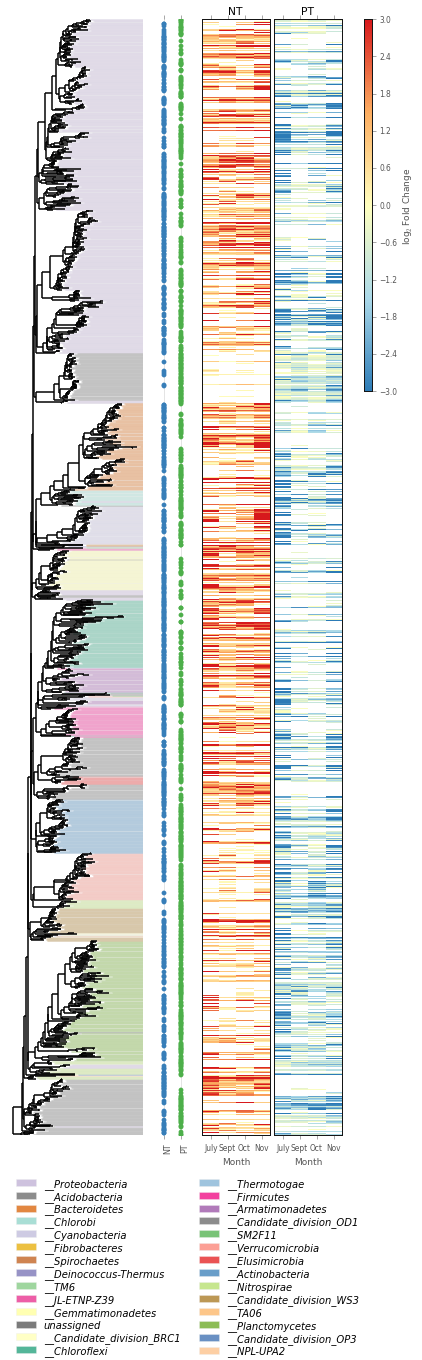

In [61]:
make_tree_fig("Bacteria", "Rank1", "Rank2", "data/l2fc_NTvsPT_all.responders.csv", "physeq", 
              save_fn = "figs/PTvsNT_tree_responders.pdf", lw_tax = 1, leg_spacing = .03,
              pt_size = 18)

## Phyla-level trees

Joining by: "OTU"


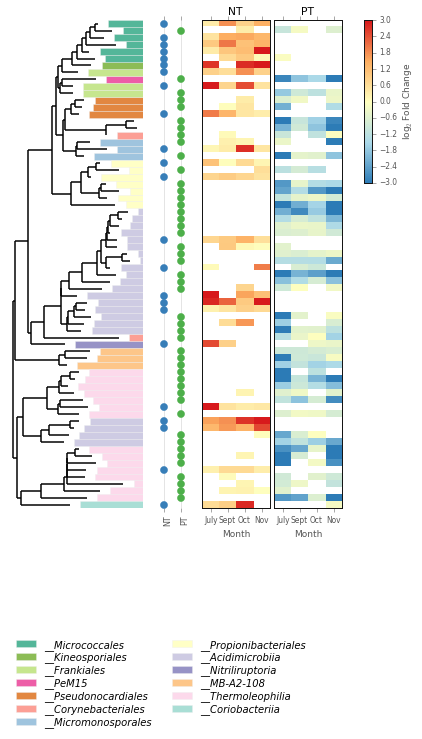

In [97]:
make_tree_fig("__Actinobacteria", "Rank2", "Rank3", "data/l2fc_NTvsPT_all.responders.csv", "physeq",
              save_fn = "figs/Actino_tree")

Joining by: "OTU"


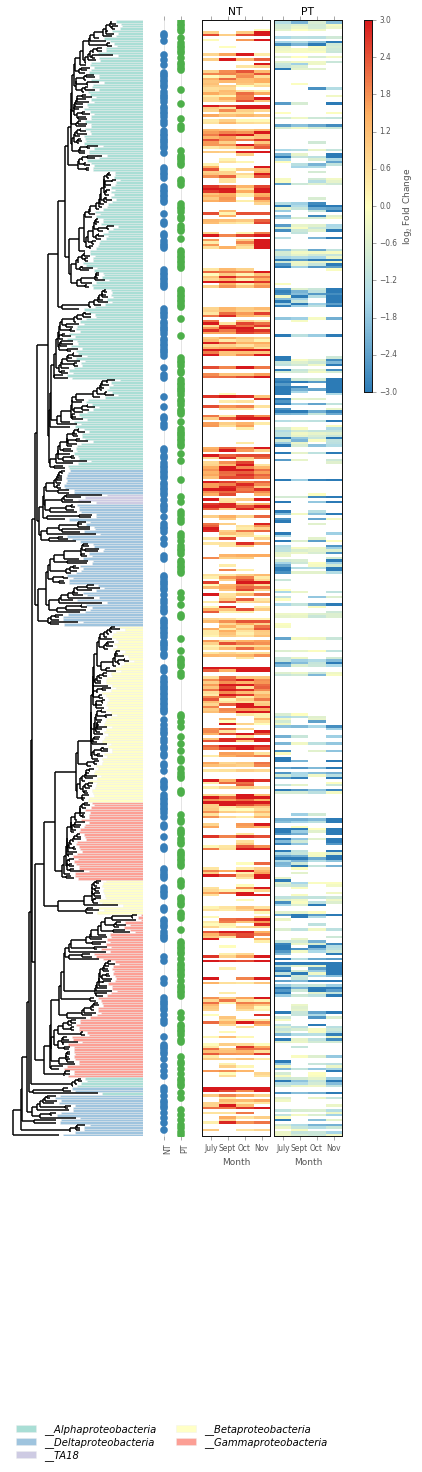

In [98]:
make_tree_fig("__Proteobacteria", "Rank2", "Rank3", "data/l2fc_NTvsPT_all.responders.csv", "physeq",
              save_fn = "figs/Proteo_tree")

Joining by: "OTU"


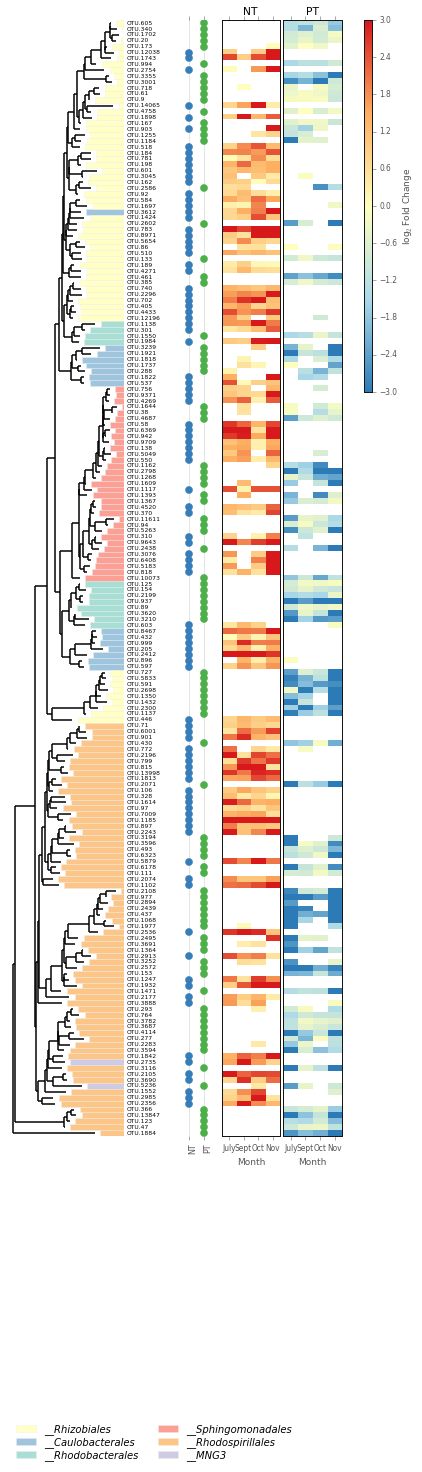

In [91]:
make_tree_fig("__Alphaproteobacteria", "Rank3", "Rank4", "data/l2fc_NTvsPT_all.responders.csv", "physeq",
              save_fn = "figs/Proteo_tree")

Joining by: "OTU"


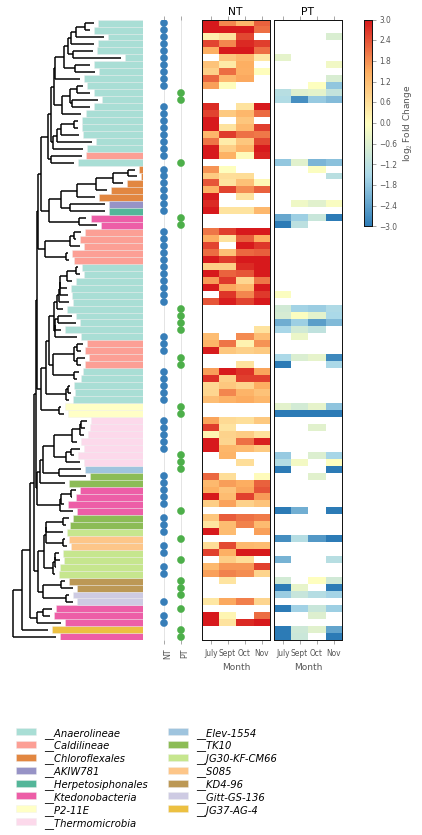

In [113]:
make_tree_fig("__Chloroflexi", "Rank2", "Rank3", "data/l2fc_NTvsPT_all.responders.csv", "physeq", leg_spacing = 0.125,
             save_fn = "figs/Chloroflexi_tree.pdf")

Joining by: "OTU"


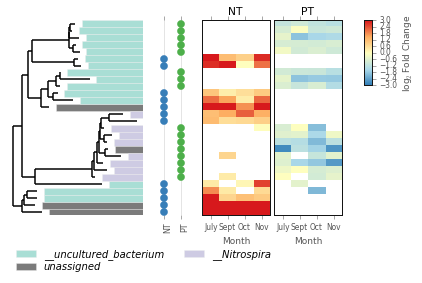

In [100]:
make_tree_fig("__Nitrospirae", "Rank2", "Rank6", "data/l2fc_NTvsPT_all.responders.csv", "physeq", leg_spacing = 0.125)

Joining by: "OTU"


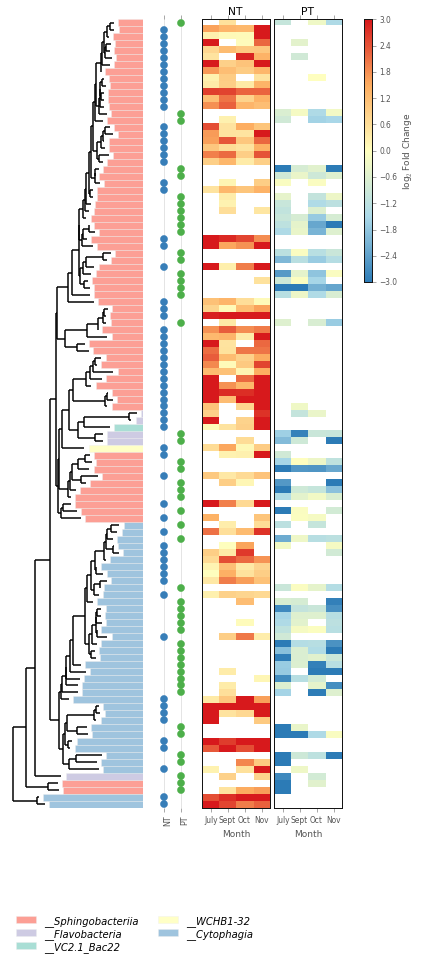

In [101]:
make_tree_fig("__Bacteroidetes", "Rank2", "Rank3", "data/l2fc_NTvsPT_all.responders.csv", "physeq", leg_spacing = 0.125,
             save_fn = "figs/Bacteroidetes_tree")

Joining by: "OTU"


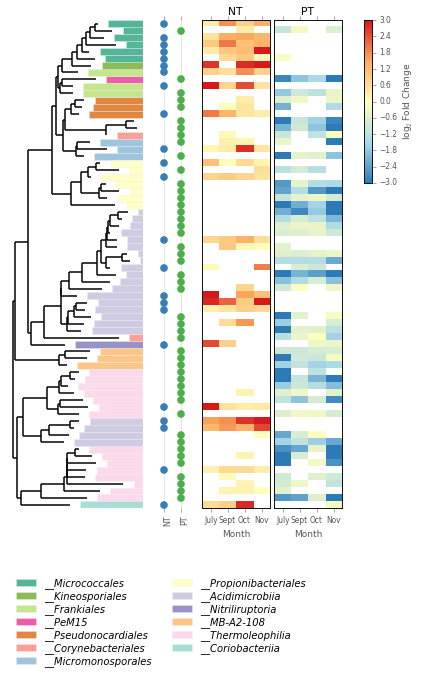

In [102]:
make_tree_fig("__Actinobacteria", "Rank2", "Rank3", "data/l2fc_NTvsPT_all.responders.csv", "physeq", leg_spacing = 0.125,
             save_fn = "figs/Actino_tree")

Joining by: "OTU"


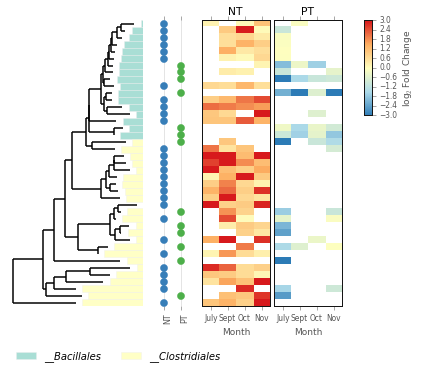

In [105]:
make_tree_fig("__Firmicutes", "Rank2", "Rank4", "data/l2fc_NTvsPT_all.responders.csv", "physeq", leg_spacing = 0.125,
             save_fn = "figs/Firm_tree")

Joining by: "OTU"


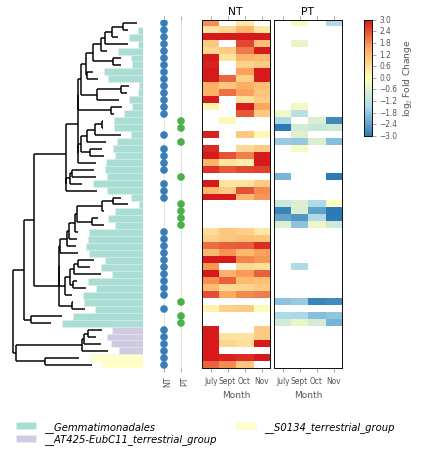

In [107]:
make_tree_fig("__Gemmatimonadetes", "Rank2", "Rank3", "data/l2fc_NTvsPT_all.responders.csv", "physeq", leg_spacing = 0.125,
             save_fn = "figs/Gem_tree")

Joining by: "OTU"


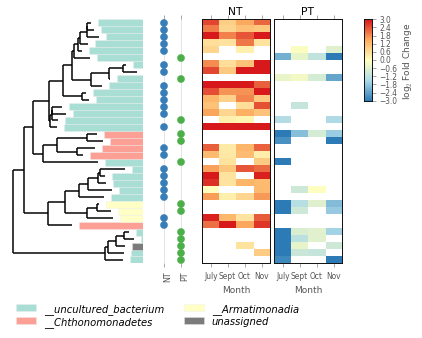

In [103]:
make_tree_fig("__Armatimonadetes", "Rank2", "Rank3", "data/l2fc_NTvsPT_all.responders.csv", "physeq", leg_spacing = 0.125,
             save_fn = "figs/Armatimon_tree")

Joining by: "OTU"


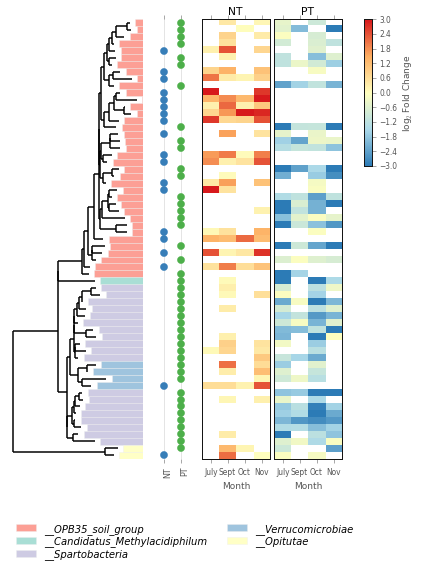

In [114]:
make_tree_fig("__Verrucomicrobia", "Rank2", "Rank3", "data/l2fc_NTvsPT_all.responders.csv", "physeq", leg_spacing = 0.125,
             save_fn = "figs/Verruco_tree.pdf")

Joining by: "OTU"


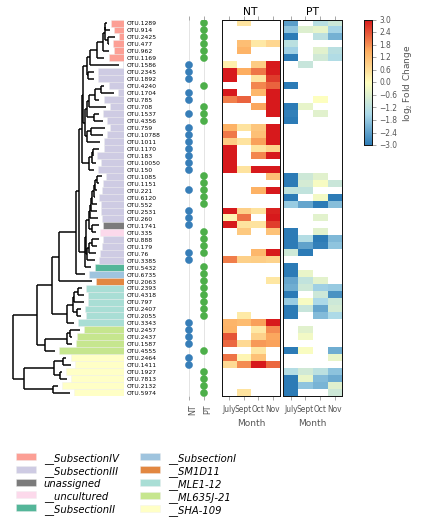

In [90]:
make_tree_fig("__Cyanobacteria", "Rank2", "Rank3", "data/l2fc_NTvsPT_all.responders.csv", "physeq", leg_spacing = 0.125,
             save_fn = "figs/Bacteroidetes_tree")

In [ ]:
make_tree_fig("__Rhizobiales", "Rank4", "Rank6", "/home/chantal/RNASIP/data/l2fc.csv", "physeq.PS.DNA", leg_spacing = 0.1)

In [ ]:
make_tree_fig("__Deltaproteobacteria", "Rank3", "Rank6", "/home/chantal/RNASIP/data/l2fc.csv", "physeq.PS.DNA", leg_spacing = 0.1)

In [ ]:
make_tree_fig("__Deltaproteobacteria", "Rank3", "Rank6", "data/l2fc.csv", "physeq.PS.DNA", leg_spacing = 0.1)

In [ ]:
make_tree_fig("__Gammaproteobacteria", "Rank3", "Rank6", "data/l2fc.csv", "physeq.PS.DNA", leg_spacing = 0.1)

In [ ]:
make_tree_fig("__Planctomycetes", "Rank2", "Rank3", "data/l2fc.csv", "physeq.PS.DNA", leg_spacing = 0.1)

In [ ]:
make_tree_fig("__Verrucomicrobia", "Rank2", "Rank3", "data/l2fc.csv", "physeq.PS.DNA", leg_spacing = 0.1)

In [ ]:
make_tree_fig("__Bacteroidetes", "Rank2", "Rank3", "data/l2fc.csv", "physeq.PS.DNA", leg_spacing = 0.1)